##  Rag System
### Objectives
- Set up a RAG system.
- Explore the distribution of embeddings with user queries.
- Implement query augmentation.
- Perform result re-ranking.
- Utilize Embedding Adapters.

Author: Rod Morrison

In [1]:
# Install packages
!pip3 install --upgrade --user google-cloud-aiplatform umap-learn tqdm pypdf

In [2]:
# Restart the kernel 
import IPython
from IPython.display import Markdown, display
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
PROJECT = !gcloud config get-value project
PROJECT_ID = PROJECT[0]
LOCATION = "us-central1"

In [3]:
# Copy files from Cloud Storage
! gsutil cp gs://crs_dev_bucket/datafiles/* .

Copying gs://crs_dev_bucket/datafiles/Gracie_Book_Intro.pdf...
/ [1 files][  3.4 MiB/  3.4 MiB]                                                
Operation completed over 1 objects/3.4 MiB.                                      


In [14]:
# Import python display utilities and Google Cloud's Embeddings and Gemini models.
from vertexai.preview.generative_models import GenerativeModel
from vertexai.language_models import TextEmbeddingModel
text_embedding_model = TextEmbeddingModel.from_pretrained("text-embedding-004")
model = GenerativeModel('gemini-pro')

# Fix the TOKENIZERS_PARALLELISM issue - put higher in notebook
import os 
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [5]:
# Convert PDF to text
!pip install PyPDF2
import PyPDF2

# Open the PDF in binary mode
with open("Gracie_Book_Intro.pdf", "rb") as file:
    # Create a PdfFileReader Object
    pdf_reader = PyPDF2.PdfReader(file)
    pdf_texts = [p.extract_text().strip() for p in pdf_reader.pages]
    
    # Filter Empty Strings
    pdf_texts = [text for text in pdf_texts if text]
    
    print(pdf_texts[0])

Gracie Jiu-Jitsu
 
by 
Grand Master
Helio Gracie
Gracie Publications
Torrance, CaliforniaREVISED EDITION


In [6]:
# Get the number of pages
num_pages = len(pdf_texts) 
print(f"The PDF has {num_pages} pages with text.")

# Get the number of characters
all_text = " ".join(pdf_texts)  # Combine all text into a single string
total_characters = len(all_text)
print(f"The PDF has a total of {total_characters} characters.")

The PDF has 23 pages with text.
The PDF has a total of 31656 characters.


### Split the PDF into chunks to create embeddinds due to token limits

In [7]:
# Install necessary libraries
!pip install langchain sentence-transformers

# Import text splitters from LangChain
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

# Initialize a RecursiveCharacterTextSplitter with specified parameters
character_splitter = RecursiveCharacterTextSplitter(
    # Define separators for splitting the text
    separators=["\n\n", "\n", ". ", " ", ""],  
    # Set the maximum chunk size to 1000 characters
    chunk_size=1000,  
    # Set chunk overlap to 0 (no overlap between chunks)
    chunk_overlap=0  
)

# Combine the extracted PDF text using newline characters as separators
pdf_text = '\n\n'.join(pdf_texts)  

# Split the combined text into chunks using the character splitter
character_split_texts = character_splitter.split_text(pdf_text)  

# Print the 11th chunk (index 10) to inspect the result
print(character_split_texts[10])  

# Print the total number of chunks created
print(f"\nTotal chunks: {len(character_split_texts)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 35.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 78.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 142.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 144.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 45.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 87.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 103.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 89.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 87.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18

### Check the exising chunks, if too big make them smaller (256 tokens)

In [8]:
# Initialize a SentenceTransformersTokenTextSplitter with specified parameters
token_splitter = SentenceTransformersTokenTextSplitter(
    # Set chunk overlap to 0 (no overlap between chunks)
    chunk_overlap=0,  
    # Set the maximum number of tokens per chunk to 256
    tokens_per_chunk=256  
)

# Create an empty list to store the tokenized chunks
token_split_texts = []  

# Iterate through the character-split chunks
for text in character_split_texts:  
    # Split each character chunk into smaller token-based chunks
    token_split_texts += token_splitter.split_text(text)  

# Print the 11th chunk (index 10) to inspect the result
print(token_split_texts[10])  

# Print the total number of token-based chunks created
print(f"\nTotal chunks: {len(token_split_texts)}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

– side kick chapter 2 – standing defenses from behind 98 – rear choke defense 100 – rear choke defense pulled back ( with side throw ) 102 – rear choke defense pulled back ( with overhead throw ) 104 – rear two - hand choke defense 106 – rear bear hug over the arms defense 108 – rear bear hug over the arms defense ( with wide stance ) 110 – rear bear hug under arms defense 112 – rear bear hug under arms defense ( with lift ) 114 – full nelson defense contents 118 – club defense ( overhead close range ) 120 – club defense ( overhead close range with slide ) 122 – club defense ( overhead distant range ) 124 – club defense ( two - hand overhead ) 126 – club defense ( horizontal swing ) 128 – chair defense 130 – knife defense ( overhead ) 132 – knife defense ( underhand ) 134 – knife defense ( underhand straight arm block ) 136 – knife defense ( underhand straight arm block with resis - tance ) 138 –

Total chunks: 43


In [9]:
!pip3 install chromadb==0.5.3  # Install ChromaDB for vector database functionality
!pip3 install google-generativeai  # Install Google Generative AI library

import chromadb  # Import ChromaDB for vector database operations
import os  # Import the os module for operating system-related functions (if needed)
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction  # Import the SentenceTransformer embedding function

# Initialize the SentenceTransformer embedding function
embedding_function = SentenceTransformerEmbeddingFunction()  

# Generate and print embeddings for a sample text chunk (token_split_texts[10])
print(embedding_function([token_split_texts[10]]))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of opentelemetry-sdk to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.5/559.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 121.4 MB/s eta 0:00:00
  Created wheel for pypika: filename=PyPika-0.48.9-py2.py3-none-any.whl size=53725 sha256=d0d7ca325c64349ffde9b4b5ee7b861a9aff7212a21644f2e9bc30b5e76dcc84
  Stored in directory: /home/jupyter/.cache/pip/wheels/e1/26/51/d0bffb3d2fd82256676d7ad3003faea3bd6dddc9577af665f4
Successfully built pypika
  Attempting uninstall: kubernetes
    Found existing installation: kubernetes 26.1.0
    Uninstall

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.0/760.0 kB 23.4 MB/s eta 0:00:00


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[[-0.004403385333716869, -0.023928439244627953, -0.03970124572515488, -0.035416942089796066, -0.010190082713961601, 0.1187557578086853, -0.05257457494735718, 0.049511704593896866, -0.06345207989215851, 0.017180215567350388, -0.005264880135655403, -0.030243538320064545, 0.07438965141773224, -0.0015706553822383285, 0.038896024227142334, 0.004807640798389912, 0.026698503643274307, 0.023080768063664436, 0.027208665385842323, 0.013869626447558403, -0.027201730757951736, 0.0034395596012473106, 0.03929683566093445, -0.012310132384300232, -0.029975978657603264, -0.05038423463702202, -0.06184713914990425, 0.008221260271966457, -0.03329555690288544, -0.10917853564023972, -0.05240422487258911, -0.027552926912903786, 0.09211231023073196, 0.05698247253894806, -0.1218724474310875, -0.03554566204547882, 0.06591395288705826, 0.04378867521882057, 0.002574281068518758, 0.0702240914106369, -0.06926540285348892, 0.009742049500346184, -0.0022185579873621464, 0.041010987013578415, 0.02624800056219101, 0.072

In [17]:
# Create embedings and store them in the chroma database.
chroma_client = chromadb.Client()
print("collection")
chroma_collection = chroma_client.create_collection("gracie_book", embedding_function=embedding_function)
print("created")
ids = [str(i) for i in range(len(token_split_texts))]
print("adding")
chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

collection
created
adding


43

In [18]:
# Ask a questions to perform an embeddings search on the chroma db database.
query = "When did Helio start teaching class?"

results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results['documents'][0]

for document in retrieved_documents:
    print(document)
    print('\n')

memorized from watching carlos teach were not very easy for him to execute. in a relentless quest to find answers that would guarantee effectiveness for jiu - jitsu techniques, helio dared to break away from the traditional jiu - jitsu his brothers had learn - ed and taught. he started to adapt the moves so that he could execute them with ease. he did so through trial and error and by incorporating leverage, which reduced the amount of strength necessary for the execution of the techniques. the beginning of a revolution the gracies had started building a reputation as effective fighters in their native brazil. the huge weight disparities and adverse conditions in some of their fights sent shockwaves throughout the country. helio, who from an early age saw carlos not only as a brother but also as a father figure, would expand the family tradition of challenge 2 gastao gracie and a young rorion. helio teaching at his house.


gracie jiu - jitsu some time later, while in his early teens, 

In [19]:
# Use a RAG to answer the question given the information that was looked up from the database.
def rag(query, retrieved_documents, model):
    information = "\n\n".join(retrieved_documents)

    prompt = (f'You are a helpful expert Gracie Jui-Jitsu assistant.\n'
    f'Your users are asking questions about information contained in the Gracie Jui-Jitsu Book.\n'
    f'You will be shown the user\'s question, and the relevant information from the Gracie Jui-Jujutsu Book.\n'
    f'Answer the user\'s question using only this information.\n\n'
    f'Question: {query}. \n Information: {information}')
    
    responses = model.generate_content(prompt, stream=False)
    return responses.text

response = rag(query=query, retrieved_documents=retrieved_documents, model=model)
print(response)

At 16 years old, Helio started teaching the sport by himself while his older brother Carlos was running late to a lesson. The student asked to continue lessons with Helio instead of Carlos after the class. Although Helio did not receive an official teacher's certification, a student basically declared him fit to teach at the young age of 16.


### Exploring Embedding Distribution with User Queries

- Visualize the distribution of embeddings in a 2D space using UMAP dimensionality reduction.  
- Analyze how queries map to the embedding space to gain insight into answer relevance.

In [20]:
# Transform embeddigns into a two-dimensional space.
import umap.umap_ as umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/home/jupyter/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
100%|██████████| 43/43 [00:04<00:00,  9.91it/s]


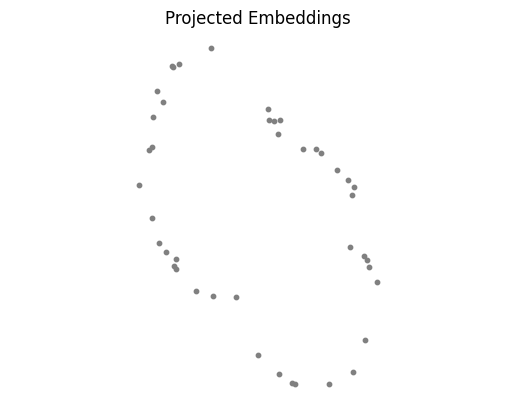

In [21]:
# Plot the two-dimensional embeddings.
import matplotlib.pyplot as plt

def plot(title='Projected Embeddings', projected_dataset_embeddings=[], projected_query_embedding=[], projected_retrieved_embeddings=[]):
    # Plot the projected query and retrieved documents in the embedding space
    plt.figure()
    plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
    if len(projected_query_embedding) > 0:
        plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
    if len(projected_retrieved_embeddings) > 0:
        plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{title}')
    plt.axis('off')

plot(projected_dataset_embeddings=projected_dataset_embeddings)

In [22]:
# Ask the same question to the database again, but this time retrieve the embeddings in addition to the documents.
query = "When did Helio start teaching class?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

memorized from watching carlos teach were not very easy for him to execute. in a relentless quest to find answers that would guarantee effectiveness for jiu - jitsu techniques, helio dared to break away from the traditional jiu - jitsu his brothers had learn - ed and taught. he started to adapt the moves so that he could execute them with ease. he did so through trial and error and by incorporating leverage, which reduced the amount of strength necessary for the execution of the techniques. the beginning of a revolution the gracies had started building a reputation as effective fighters in their native brazil. the huge weight disparities and adverse conditions in some of their fights sent shockwaves throughout the country. helio, who from an early age saw carlos not only as a brother but also as a father figure, would expand the family tradition of challenge 2 gastao gracie and a young rorion. helio teaching at his house.

gracie jiu - jitsu some time later, while in his early teens, h

In [23]:
# Embed the question and answer and transform it into two dimentions
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:00<00:00, 194.44it/s]


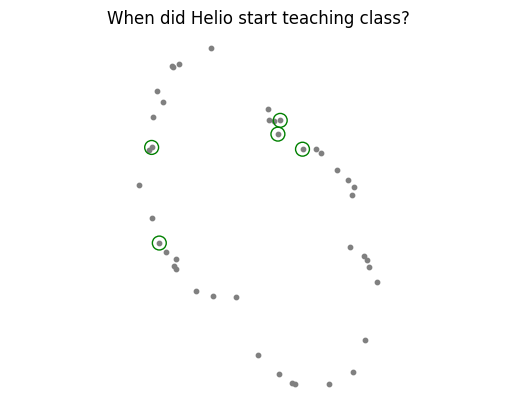

In [24]:
# Plot the projected query and retrieved documents in the embedding space.
plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=[], projected_retrieved_embeddings=projected_retrieved_embeddings)

In [25]:
# Use a different question to see another example
query = "Who was the Great Kimura?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

5making him reconsider. while debating if he should tap, the crowd became silent and the lights faded to black. helio had lost consciousness. that was when one of the most bizarre incidents in sports history took place. unaware that his opponent was unconscious, kimura decided to try something else and jumped into the mount position, which allowed helio to breathe again! the little big man, who had passed out with his eyes wide open, was awakened by a towering kimura saying, “ good, very good! ” while wiping the sweat off his brow. amazingly, the fight had never stopped. the match went on for thirteen minutes and eventually kimura caught helio in his famous “ kimura ” lock. carlos, fearing that helio might not tap and would receive a ser - ious injury, threw in the towel, forfeiting the match to the japanese champion. kimura was so impressed with helio ’ s performance that the day after the match, he went to the gracie academy in rio to invite helio to teach in japan.

when jiu - jitsu

In [26]:
# Create embeddings and projections
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:00<00:00, 286.23it/s]


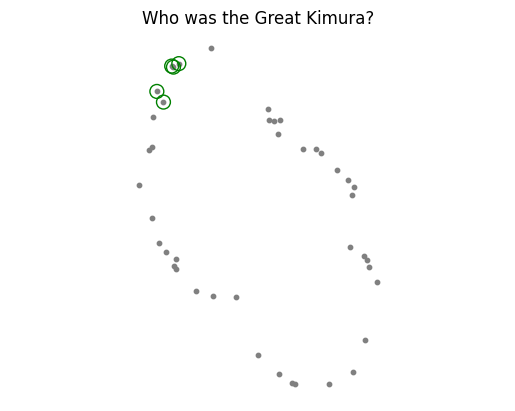

In [28]:
# Plot the projected query and retrieved documents in the embedding space. 
plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=[], projected_retrieved_embeddings=projected_retrieved_embeddings)

7while staying at the ymca in hollywood, for security reasons he asked the receptionist to place his return airline ticket, along with his cash, in their safe. a few days later, when he went to get some spending money, he found out that a receptionist had stolen his money and his ticket. not wanting to alarm his parents, he told them he had decided to stay longer in california. through a friend, he got a job at a hamburger stand in the san fernando valley, just northwest of los angeles. within a few days, he moved in with the family of a co - worker. those were the days of flower - power and

rock - and - roll. jimi hendrix and janis joplin were at the top of the charts. after six months, rorion started to get bored and was eager to return home to brazil. because he was so close, though, he decided to see hawaii. it was won - derful – until the money ran out. then, the tropical paradise changed dramatically. while looking for a job, he was so broke that he actually had to panhandle and

100%|██████████| 5/5 [00:00<00:00, 173.93it/s]


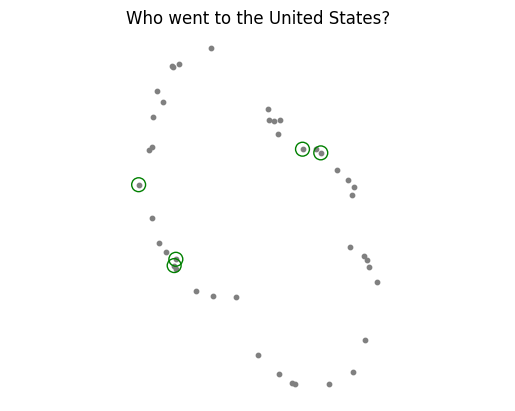

In [29]:
# Let's do all these again with another question that might be contained in the dataset to see that results are still close to one another
query = "Who went to the United States?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=[], projected_retrieved_embeddings=projected_retrieved_embeddings)

really good, so we scheduled a meeting. the next day, an unassuming thomas de soto walked into my office. tommy ’ s portfolio was extremely impressive. his lenses have captured everything from komodo dragons in indonesia and alligators in africa, to a who ’ s who list of celebrities and sports legends, covering everyone from mick jagger to tiger woods. tommy ’ s photographic talents were the perfect complement for the book i ’ d been dreaming of. after the usual small talk, i fired off the sixty - four - dollar question, “ how much do you charge? ” with a small smile, he replied, “ my going rate is $ $ $ $ $ an hour. ” “ it was nice meeting you, ” i replied, standing up and reaching out to shake his hand, “ but i can ’ t afford that. ” tommy smiled again and said, “ but i ’ m not going to charge you anything. ” for several moments i was speechless – which is unusual for me. then i sat back down and managed to say, “ why is that? ”

found its way to south america, more specifically, the

100%|██████████| 5/5 [00:00<00:00, 282.78it/s]


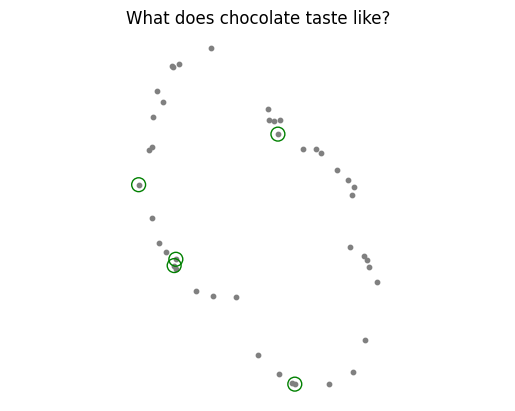

In [30]:
# Ask an unrelated question and observe the results

query = "What does chocolate taste like?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=[], projected_retrieved_embeddings=projected_retrieved_embeddings)

### Query Augmentation & Better Results
- Improving query results can be achieved by expanding the search with similar queries or by providing expected answers to add context.  
- We can use LLMs to automatically generate these enhanced queries.

In [34]:
# Augment the query with a probable answer to give more context to the vector search
def augment_query_generated(query, model):
    information = "\n\n".join(retrieved_documents)

    prompt = (f'You are a helpful expert Gracie Jui-Jitsu assistant\n'
    f'Provide an example answer to the given question, that might be found in a document like the Gracie Jui-Jitsu Book.\n'
    f'Question: {query}.')
    
    responses = model.generate_content(prompt, stream=False)
    return responses.text

original_query = "What was the Helio Gracie's longest fight?"
hypothetical_answer = augment_query_generated(original_query, model)

joint_query = f"{original_query} {hypothetical_answer}"
print(joint_query)

What was the Helio Gracie's longest fight? ##  Helio Gracie's Longest Fight: A Testament to Endurance and Willpower

Helio Gracie, the founder of Gracie Jiu-Jitsu, is renowned for his incredible fighting spirit and endurance. This was never more evident than in his legendary three-hour match against Japanese judoka Masahiko Kimura in 1951.

This grueling encounter, held at the Maracanã Stadium in Rio de Janeiro, captivated the attention of millions. Despite the massive size and strength advantage of Kimura, Helio refused to yield. He employed his masterful Jiu-Jitsu techniques, focusing on control and leverage, to counter Kimura's attacks.

The fight was a masterclass in Jiu-Jitsu principles. Helio utilized his guard effectively, preventing Kimura from taking a dominant position. He capitalized on every opportunity to sweep and attack, showcasing the immense power of technique over brute force.

As the hours passed, the intensity of the fight remained relentless. Both fighters displaye

In [35]:
# Perform the query with the new augmented query
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(doc)
    print('')

the world ’ s longest fight when he was forty - two years old, helio came out of retirement for an epic no - holds - barred battle against a former top student, twenty - five - year - old waldemar santana. the match lasted for three hours and forty minutes and set the world record for the longest uninterrupted fight in history. helio took the fight on short notice and without any preparation, when santana, influenced by a disgruntled reporter, made disrespectful comments towards helio. the helio and kimura.

gracie jiu - jitsu 4the world, who was almost forty lbs. heavier than helio, could beat him just as easily. helio seized that statement as an opportunity to get to kimura. he offered to fight kato in a qualifying match and ended - up actually fighting kato twice. in their first match, helio fought with a broken rib he received during training one week prior. in spite of the serious risk and against doctor ’ s orders, helio fought kato to a draw. a month later, helio and kato. durin

In [36]:
# Search for embeddings for the augmented query
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(doc)
    print('')

the world ’ s longest fight when he was forty - two years old, helio came out of retirement for an epic no - holds - barred battle against a former top student, twenty - five - year - old waldemar santana. the match lasted for three hours and forty minutes and set the world record for the longest uninterrupted fight in history. helio took the fight on short notice and without any preparation, when santana, influenced by a disgruntled reporter, made disrespectful comments towards helio. the helio and kimura.

gracie jiu - jitsu 4the world, who was almost forty lbs. heavier than helio, could beat him just as easily. helio seized that statement as an opportunity to get to kimura. he offered to fight kato in a qualifying match and ended - up actually fighting kato twice. in their first match, helio fought with a broken rib he received during training one week prior. in spite of the serious risk and against doctor ’ s orders, helio fought kato to a draw. a month later, helio and kato. durin

In [37]:
# Get the embeddings for the queries and results and then map them to a 2-dimensional space
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:00<00:00, 304.54it/s]


(-5.776494777202606, -0.6000656723976135, 8.835887813568116, 16.12125406265259)

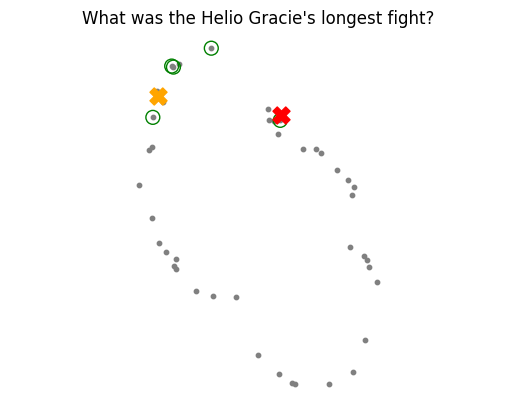

In [38]:
# Map the results to get a visual understanding of the outcome. 
# Notice that the seleted answers are closer to the augmented query datapoint
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

In [39]:
# Augment the query with a additional queries
def augment_multiple_query(query, model):
    information = "\n\n".join(retrieved_documents)

    prompt = (f'You are a helpful expert Gracie Jui-Jitsu assistant.\n'
    f'Your users are asking questions about Gracie Jui-Jitsu history and techniques\n'
    f'Suggest up to five additional related questions to help them find the information they need, for the provided question.\n'
    f'Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic.\n'
    f'Make sure they are complete questions, and that they are related to the original question.\n'
    f'Output one question per line. Do not number the questions.\n'
    f'Question: {query}.')
    
    responses = model.generate_content(prompt, stream=False)
    return responses.text

original_query = "What are atrributes that can be applied to everyday life from Gracie Jui-Jutsu?"
augmented_queries = augment_multiple_query(original_query, model)

joint_query = f"{original_query} \n{augmented_queries}"
print(joint_query)

What are atrributes that can be applied to everyday life from Gracie Jui-Jutsu? 
1. How can Gracie Jui-Jitsu help build confidence?
2. What are some self-defense techniques from Gracie Jui-Jitsu that can be used in everyday situations?
3. How does Gracie Jui-Jitsu promote discipline and self-control?
4. Does Gracie Jui-Jitsu help improve mental and physical health?
5. What are some of the core values of Gracie Jui-Jitsu that can be applied to everyday life?


In [40]:
# Retrieve answers for all of these queries
queries = [original_query] + augmented_queries.split('\n')
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(doc)
        print('')
    print('-'*100)

Query: What are atrributes that can be applied to everyday life from Gracie Jui-Jutsu?

Results:
that in order to be truly prepared for the reality of a street fight, one must incorporate some version of the jiu - jitsu style perfected by helio gracie. in fact, gracie jiu - jitsu ' s humane approach, which enables its practitioners to con - trol an attacker without hurting them, has a wide variety of specialized applications. these include : gracie resisting attack procedures for law enforcement® ( g. r. a. p. l. e. ), now gst, which has reached every major federal law enforcement agency and military organization, as well as many state and local police departments in the u. s. in fact, the u. s. army has rewritten their hand - to - hand combat manual to include the techniques of gracie jiu - jitsu. women empowered® was designed to enable virtually all women to avoid and escape a sexual assault. this unique program does not require strength, speed or coordination. gracie bullyproof® is 

In [41]:
# Put the queries embeddings into a 2-dimensional space
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)

100%|██████████| 380/380 [00:01<00:00, 281.38it/s]


In [42]:
# Put the answer embeddings into a 2-dimensional space
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

100%|██████████| 30/30 [00:00<00:00, 321.80it/s]


(-5.781894585490226, -0.4866696983575821, 8.835887813568116, 16.12125406265259)

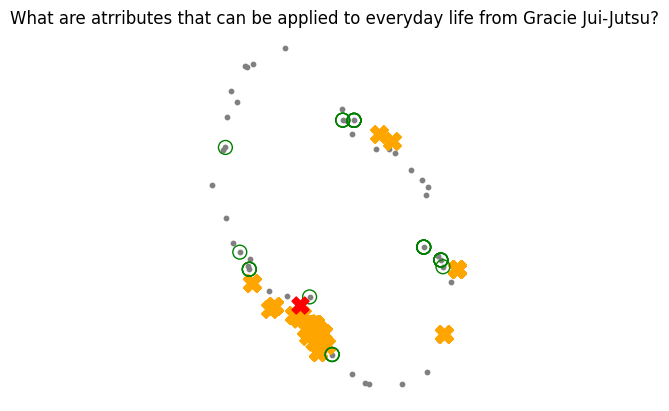

In [43]:
# Plot the queries and answers to visualize their representation in space
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

### Re-ranking Search Results

*   **Challenge:** Query expansion increases the number of responses, potentially exceeding LLM input limits and increasing costs (billed per token).
*   **Solution:** Re-rank results to select only the most relevant responses for processing.
*   **Method:** Use a cross-encoder model instead of cosine-similarity for improved accuracy in ranking.

In [44]:
# Import a cross encoder model
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [45]:
# Create unique pairs of query to document
pairs = []
for doc in unique_documents:
    pairs.append([original_query, doc])

In [46]:
# Compute an print the similarity between the pairs
scores = cross_encoder.predict(pairs)

print("Scores:")
for score in scores:
    print(score)

Scores:
-6.512203
-8.9254465
-9.081492
-11.040601
-6.667387
-7.1736236
-8.029073
-4.7693424
-6.4353523
-2.221586


In [47]:
# Reorder the pairs in terms of relevance
print("New Ordering:")
ranked_docs=['']*len(scores)
i = 0
for position in np.argsort(scores)[::-1]:
    ranked_docs[position] = pairs[i][1]
    i+=1
    print(position)

New Ordering:
9
7
8
0
4
5
6
1
2
3


In [48]:
# Print the 5 most relevant documents
ranked_docs[:5]

['standing defenses from the front it is a fact that most fights end up on the ground. it is also true that confrontations start with two people on their feet, so you must be prepared to react to any and all possible standing surprise attacks. the techniques in this section are the most effective ways to defend such attacks. 20gracie jiu - jitsu 1 2 3 4 5 6 hip throw helio reaches out and holds the back of rorion ’ s elbow [ 1, 2 ]. lifting the arm and trapping the wrist under his armpit [ 3 ], helio steps to the side, under rorion ’ s free arm, and holds the waist [ 4 ]. he then loosens the back hand, which allows him to step across and bring his hips directly in front of his opponent with knees slightly bent [ 5 ]. as he readjusts his back hand, pinning the opponent ’ s hips to his own, he brings his head to his left knee while straightening his legs [ 6 ]',
 'acknowledgements for many years i felt that gracie jiu - jitsu, arguably the most revolutionary style in martial arts history

In [49]:
# Only send the most relevant answers to the LLM
response = rag(query=original_query, retrieved_documents=ranked_docs[:5], model=model)
print(original_query)
print(response)

What are atrributes that can be applied to everyday life from Gracie Jui-Jutsu?
## Attributes of Gracie Jiu-Jitsu Applicable to Everyday Life

Gracie Jiu-Jitsu offers attributes that extend far beyond self-defense techniques. These principles can be applied to various aspects of everyday life, fostering personal growth and well-being.

**Confidence:** Training in Gracie Jiu-Jitsu instills a deep sense of self-confidence. As you learn to overcome challenges and master new skills, you develop a belief in your abilities, empowering you to face any situation with composure and determination.

**Discipline:** The practice of Gracie Jiu-Jitsu demands discipline. You learn to focus your mind, control your body, and persevere through demanding training sessions. This discipline translates to other areas of your life, enabling you to set goals, stay focused, and achieve your desired outcomes.

**Humility:** Gracie Jiu-Jitsu teaches the importance of humility. Every training session presents an 

### Embedding Adapters

*   **Alternative:** Instead of query expansion and re-ranking, consider adapting the embedding model itself.
*   **Method:** Fine-tune the embedding model on your dataset using user queries.
*   **Benefit:** This allows the model to better understand the domain-specific nuances in your data.

In [51]:
# Generate queries that might be asked about Gracie Jui-Jutsu. If you had real users, you would use those queries instead of making them up
def generate_queries(model):

    prompt = (f'You are a helpful expert Helio Gracie Jui-Jitsu assistant.\n'
    f'You help users analyze Helio Gracie Jui-Jutsu to better understand how it can help in all aspects of life.\n'
    f'Suggest 10 to 15 short questions that are important to ask when practicing Helio Gracie Jui-Jutsu .\n'
    f'Do not output any compound questions (questions with multiple sentences or conjunctions).\n'
    f'Output each question on a separate line divided by a newline.')
    
    responses = model.generate_content(prompt, stream=False)
    return responses.text.split('\n')

generated_queries = generate_queries(model)
for query in generated_queries:
    print(query)

## 10-15 Important Questions to Ask When Practicing Helio Gracie Jui-Jitsu:

1. Am I maintaining a strong and stable base?
2. Is my grip secure and efficient?
3. Am I using my leverage effectively?
4. Am I breathing properly and staying calm?
5. Am I controlling my opponent's balance?
6. Am I transitioning smoothly between techniques?
7. Am I aware of my surroundings and potential threats?
8. Am I respecting my training partners and the art?
9. Am I learning from my mistakes and improving my skills?
10. Am I enjoying the process and staying motivated?
11. How can I apply this technique to a real-world situation?
12. What are the different variations of this technique?
13. How can I modify this technique to suit my body type and strengths?
14. What are the common mistakes associated with this technique?
15. How can I use this technique to control and subdue an opponent? 



In [52]:
# Search answers for those queries
results = chroma_collection.query(query_texts=generated_queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

In [53]:
# Evaluate the results in 1 for relevant and -1 for irrelevant answers
def evaluate_results(query, statement, model):

    prompt = (f'You are a helpful expert Helio Gracie Jui-Jitsu assistant.\n'
    f'You help users analyze Helio Gracie Jui-Jutsu to better understand how it can help in all aspects of life.\n'
    f'For the given query, evaluate whether the following satement is relevant.\n'
    f'Output only \'yes\' or \'no\'.\n'
    f'Question: {query}, Statement: {statement}.')
    
    responses = model.generate_content(prompt, stream=False)
    if responses.text == 'yes':
        return 1
    return -1

retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

In [54]:
# Extract the documents and queries into their own lists
adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []

for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document, model))

len(adapter_labels)

100%|██████████| 18/18 [01:49<00:00,  6.07s/it]


180

In [55]:
# Install PyTorch so that we can train the embedding model based on relevant answers
!pip install torch

import torch

In [56]:
# Initialize PyTorch with the right data
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

In [57]:
# Set up the model with cosine similarity, so that embeddings with label 1 are similar and -1 are dissimilar
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)

In [58]:
# Compute the mean squared error (MSE) loss to see how close are we to the expected output
def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

In [59]:
# Initialize the adaptor matrix
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

### Training the Adapter Matrix

*   **Process:**  The adapter matrix is trained over 100 steps.
*   **Mechanism:**
    *   A vector is iteratively updated.
    *   This vector is multiplied by query embeddings.
    *   The result is compared to the corresponding document vector.
*   **Goal:** To obtain a score that aligns with the example's label (-1 or 1).

In [60]:
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()       

  0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


In [63]:
# Print the best (lowest) loss achieved during training.
print(f"Best loss: {min_loss.detach().numpy()}")

Best loss: 0.6666986346244812


In [64]:
# Create a scaled vector based on the best matrix that we computed
test_vector = torch.ones((mat_size,1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

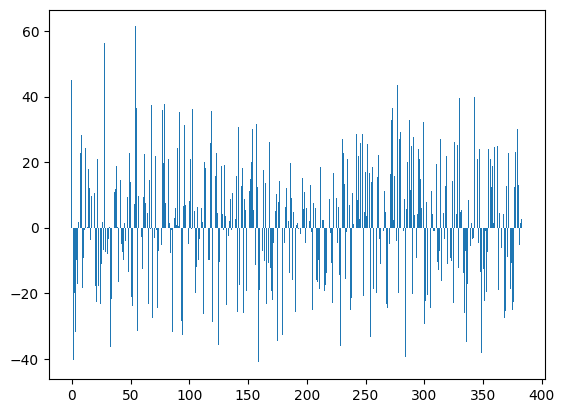

In [65]:
# Plot the scale vector answers
import matplotlib.pyplot as plt
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()

In [66]:
# Get the adapted query embeddings to compare them with the original values retrieved
query_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

100%|██████████| 18/18 [00:00<00:00, 265.10it/s]


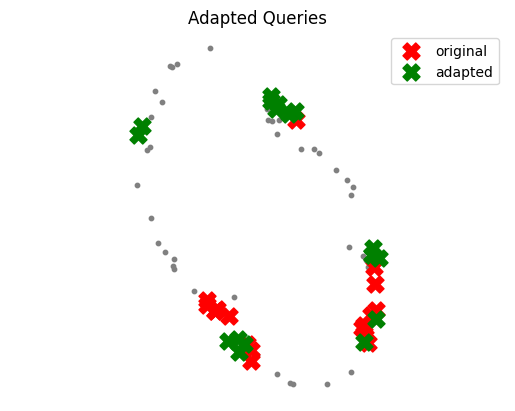

In [67]:
# Plot the adapted embeddings and the original values retrieved
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()